In [1]:
import pandas as pd
import os
import numpy as np
import json

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

%matplotlib inline
import sklearn.metrics as skl_metrics

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)

## Handle Sybil annotation info

In [3]:
SYBIL_ANNOT_PATH = f"{TEAMS_DIR}/sybil-train-info/sybil-nlst-train-annotations.json"
with open(SYBIL_ANNOT_PATH, "r") as f:
    sybil_annots = json.load(f)

sybil_annots

{'1.2.840.113654.2.55.38995485391900019876570761037952058249': {'1.2.840.113654.2.55.275160439012050074323170831804208812984': [{'x': 0.17459896484375,
    'y': 0.30871669921875,
    'width': 0.04600482421875,
    'height': 0.0411622265625}],
  '1.2.840.113654.2.55.98336108916096429974899588868734477535': [{'x': 0.1637030859375,
    'y': 0.3111380078125,
    'width': 0.052058125,
    'height': 0.04479419921875}],
  '1.2.840.113654.2.55.280972815401648915903374779039953078123': [{'x': 0.14191130859375,
    'y': 0.59443099609375,
    'width': 0.05811138671875,
    'height': 0.0532687890625}],
  '1.2.840.113654.2.55.247917605354156964140382450551544417059': [{'x': 0.135858046875,
    'y': 0.58111380859375,
    'width': 0.07627119140625,
    'height': 0.07263921875}],
  '1.2.840.113654.2.55.237930085150267046743514220912827705415': [{'x': 0.58745046875,
    'y': 0.69875423828125,
    'width': 0.07021515625,
    'height': 0.0520951171875}],
  '1.2.840.113654.2.55.622628924705130611737708118

In [4]:
sybil_ser_iuids = pd.Series(list(sybil_annots.keys()))
sybil_sop_iuids = pd.Series(sum([list(a.keys()) for a in sybil_annots.values()], start=[]))
len(sybil_ser_iuids), len(sybil_sop_iuids)

(972, 9273)

In [5]:
sybil_sop_iuids.nunique(), sybil_ser_iuids.nunique()

(9273, 972)

In [7]:
sybil_ser_iuids.head()

0    1.2.840.113654.2.55.38995485391900019876570761...
1    1.2.840.113654.2.55.50761756412482430061802871...
2    1.2.840.113654.2.55.24023112856488152536348979...
3    1.2.840.113654.2.55.24785488463405747713776937...
4    1.2.840.113654.2.55.15708941008648745210499888...
dtype: object

In [8]:
nlst_others = pd.read_csv(f"{NLST_PREDS}/nlst_kiran_thijmen_pancan_16077.csv")
kiran_ser_iuids = pd.unique(nlst_others['SeriesInstanceUID'])
kiran_ser_iuids

array(['1.2.840.113654.2.55.240231128564881525363489796879328810792',
       '1.2.840.113654.2.55.50761756412482430061802871163319122196',
       '1.2.840.113654.2.55.125678454609249687113295452275381538966', ...,
       '1.3.6.1.4.1.14519.5.2.1.7009.9004.796552648301224162316340948265',
       '1.3.6.1.4.1.14519.5.2.1.7009.9004.698887010763542043410231186032',
       '1.3.6.1.4.1.14519.5.2.1.7009.9004.513699984521040918361880189881'],
      dtype=object)

In [9]:
match_ser_iuds = set(kiran_ser_iuids).intersection(set(sybil_ser_iuids))

In [10]:
len(match_ser_iuds)

648

## Load Sybil PID to Splits CSV

In [5]:
pidtosplit = pd.read_csv(f"{NLST_PREDS}/sybil-nlst-pid2split.csv")
pidtosplit.head()

PID  SPLIT
0  122361   test
1  113845  train
2  204631  train
3  126153  train
4  101643   test

In [6]:
pidtosplit['SPLIT'].value_counts(dropna=False)

SPLIT
train    10200
dev       2472
test      2328
Name: count, dtype: int64

In [9]:
import pickle
import re

SYBIL_SERIES_JSON_PATH = f"{NLST_PREDS}/sybil-nlst-pid_tp_series2split.p"

sybil_siuid_dict = pickle.load(open(SYBIL_SERIES_JSON_PATH, "rb"))

ids = list(sybil_siuid_dict.keys())
splits = list(sybil_siuid_dict.values())
pids = [re.split('PID-|__TimePoint-|__Series-', i)[1] for i in ids]
timepoints = [re.split('PID-|__TimePoint-|__Series-', i)[2] for i in ids]
siuids = [re.split('PID-|__TimePoint-|__Series-', i)[3] for i in ids]


sybil_siuid_df = pd.DataFrame({'id': ids, 'split': splits, 'pid': pids, 'timepoint': timepoints, 'SeriesInstanceUID': siuids})
sybil_siuid_df

id  split     pid  \
0      PID-204631__TimePoint-0__Series-1.3.6.1.4.1.14...  train  204631   
1      PID-204631__TimePoint-1__Series-1.3.6.1.4.1.14...  train  204631   
2      PID-204631__TimePoint-2__Series-1.3.6.1.4.1.14...  train  204631   
3      PID-126153__TimePoint-2__Series-1.2.840.113654...  train  126153   
4      PID-126153__TimePoint-1__Series-1.2.840.113654...  train  126153   
...                                                  ...    ...     ...   
41275  PID-133831__TimePoint-2__Series-1.2.840.113654...   test  133831   
41276  PID-133831__TimePoint-0__Series-1.2.840.113654...   test  133831   
41277  PID-116981__TimePoint-0__Series-1.2.840.113654...   test  116981   
41278  PID-116981__TimePoint-2__Series-1.2.840.113654...   test  116981   
41279  PID-116981__TimePoint-1__Series-1.2.840.113654...   test  116981   

      timepoint                                  SeriesInstanceUID  
0             0  1.3.6.1.4.1.14519.5.2.1.7009.9004.186764828479...  
1             1  1.3.6.1.4.1.14519.5.2.1.7009.9004.154974321095...  
2             2  1.3.6.1.4.1.14519.5.2.1.7009.9004.181632252038...  
3             2  1.2.840.113654.2.55.43665829455927473870872470...  
4             1  1.2.840.113654.2.55.18862732764668567267836753...  
...         ...                                                ...  
41275         2  1.2.840.113654.2.55.26279217761753193890516762...  
41276         0  1.2.840.113654.2.55.23986337370551290634823184...  
41277         0  1.2.840.113654.2.55.16179604920107519147811774...  
41278         2  1.2.840.113654.2.55.59492406653704762882979549...  
41279         1  1.2.840.113654.2.55.64498551494685723700722207...  

[41280 rows x 5 columns]

In [14]:
sybil_siuid_df.to_csv(f"{NLST_PREDS}/sybil-nlst-splitinfo.csv", index=False)

In [10]:
sybil_siuid_df['split'].value_counts()

split
train    28160
dev       6838
test      6282
Name: count, dtype: int64

In [12]:
sybil_siuid_df.groupby('split').nunique()

id   pid  timepoint  SeriesInstanceUID
split                                           
dev     6838  2336          3               6838
test    6282  2203          3               6282
train  28160  9646          3              28160

In [21]:
sybil_siuid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41280 entries, 0 to 41279
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 41280 non-null  object
 1   split              41280 non-null  object
 2   pid                41280 non-null  object
 3   timepoint          41280 non-null  object
 4   SeriesInstanceUID  41280 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


In [66]:
sybil_siuid_df['pid'] = sybil_siuid_df['pid'].astype(int)
sybil_siuid_df['timepoint'] = sybil_siuid_df['timepoint'].astype(int)

In [67]:
sybil_siuid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41280 entries, 0 to 41279
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 41280 non-null  object
 1   split              41280 non-null  object
 2   pid                41280 non-null  int64 
 3   timepoint          41280 non-null  int64 
 4   SeriesInstanceUID  41280 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


### Find intersections between Sybil and Kiran and Tijmen

In [19]:
sybil_train_seriesids = pd.unique(sybil_siuid_df.query('split == "train"')['SeriesInstanceUID'])
sybil_dev_seriesids = pd.unique(sybil_siuid_df.query('split == "dev"')['SeriesInstanceUID'])
sybil_test_seriesids = pd.unique(sybil_siuid_df.query('split == "test"')['SeriesInstanceUID'])
len(sybil_train_seriesids), len(sybil_dev_seriesids), len(sybil_test_seriesids)

(28160, 6838, 6282)

In [20]:
## Sanity check
set2 = set(sybil_train_seriesids).intersection(set(sybil_dev_seriesids))
set3 = set(sybil_train_seriesids).intersection(set(sybil_test_seriesids))
set4 = set(sybil_dev_seriesids).intersection(set(sybil_test_seriesids))
len(set2), len(set3), len(set4)

(0, 0, 0)

In [21]:
len(kiran_ser_iuids)

10183

In [22]:
match_train_ids = set(kiran_ser_iuids).intersection(set(sybil_train_seriesids))
match_dev_ids = set(kiran_ser_iuids).intersection(set(sybil_dev_seriesids))
match_test_ids = set(kiran_ser_iuids).intersection(set(sybil_test_seriesids))
len(match_train_ids), len(match_dev_ids), len(match_test_ids), len(kiran_ser_iuids) - len(match_train_ids)

(4271, 947, 757, 5912)

In [23]:
nlst_tijmen = nlst_others[~nlst_others['Thijmen_mean'].isna()]
tijmen_ser_iuids = pd.unique(nlst_tijmen['SeriesInstanceUID'])
len(tijmen_ser_iuids)

2062

In [24]:
match_train_ids2 = set(tijmen_ser_iuids).intersection(set(sybil_train_seriesids))
match_dev_ids2 = set(tijmen_ser_iuids).intersection(set(sybil_dev_seriesids))
match_test_ids2 = set(tijmen_ser_iuids).intersection(set(sybil_test_seriesids))
len(match_train_ids2), len(match_dev_ids2), len(match_test_ids2), len(tijmen_ser_iuids) - len(match_train_ids2)

(890, 197, 143, 1172)

In [25]:
sybil_siuids_to_use = set(tijmen_ser_iuids) - set(sybil_train_seriesids)
len(sybil_siuids_to_use)

1172

In [27]:
nlst_preds = pd.read_csv(f'{NLST_PREDS}/nlst_demo_v1_w4preds.csv')
nlst_preds['InSybilTrain'] = nlst_preds['SeriesInstanceUID'].isin(sybil_train_seriesids)
nlst_preds['InSybilTrain'].value_counts()

InSybilTrain
False    9545
True     6532
Name: count, dtype: int64

In [30]:
nlst_preds.to_csv()

PatientID  StudyDate                                  SeriesInstanceUID  \
0     100012   19990102  1.2.840.113654.2.55.24023112856488152536348979...   
1     100012   20000102  1.2.840.113654.2.55.50761756412482430061802871...   
2     100019   20000102  1.2.840.113654.2.55.12567845460924968711329545...   
3     100035   19990102  1.2.840.113654.2.55.64360087057061878755830205...   
4     100035   20000102  1.2.840.113654.2.55.33941066798745864774354503...   

       CoordX     CoordY       CoordZ  LesionID NoduleType  Spiculation  \
0  -32.919853 -136.22139   -90.400002         1      Solid        False   
1  -47.650000 -130.37000  1222.350000         1  PartSolid        False   
2 -103.190000   74.01000 -1129.370000         1      Solid        False   
3  124.670000    5.85000  -193.590000         1      Solid        False   
4  127.360000   -2.95000  -184.570000         1      Solid        False   

   Diameter [mm]  ...  cancnasa  cancoral  cancpanc  cancphar  cancstom  \
0           11.5  ...       0.0       0.0       0.0       0.0       0.0   
1           23.4  ...       0.0       0.0       0.0       0.0       0.0   
2           10.6  ...       0.0       0.0       0.0       0.0       0.0   
3            5.0  ...       0.0       0.0       0.0       0.0       0.0   
4            4.8  ...       0.0       0.0       0.0       0.0       0.0   

   cancthyr  canctran  study  Thijmen_local  InSybilTrain  
0       0.0       0.0      1       0.968842         False  
1       0.0       0.0      1       0.984129         False  
2       0.0       0.0      1       0.919277         False  
3       0.0       0.0      1       0.002378          True  
4       0.0       0.0      1       0.000555         False  

[5 rows x 90 columns]

In [29]:
nlst_preds.drop_duplicates(subset=['SeriesInstanceUID'])['InSybilTrain'].value_counts()

InSybilTrain
False    5912
True     4271
Name: count, dtype: int64

In [32]:
nlst_preds[(~nlst_preds['Thijmen_mean'].isna()) & (nlst_preds['InSybilTrain'] == False)]['SeriesInstanceUID'].nunique()

1172

In [33]:
nlst_preds.to_csv(f'{NLST_PREDS}/nlst_demo_v1_w4preds.csv', index=False)

## Get Demographic info for Sybil data split

In [2]:
sybil_siuid_df = pd.read_csv(f"{NLST_PREDS}/sybil-nlst-splitinfo.csv")
sybil_siuid_df['pid'] = sybil_siuid_df['pid'].astype(int)
sybil_siuid_df['timepoint'] = sybil_siuid_df['timepoint'].astype(int)
sybil_siuid_df['pid'].nunique()
# sybil_siuid_df.info()

14185

In [4]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [5]:
nlst_democols

{'num': {'demo': ['height', 'weight', 'Age', 'BMI'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr'],
  'nodule': ['CoordX', 'CoordY', 'CoordZ'],
  'other': ['NoduleCounts', 'Diameter [mm]'],
  'lungcanc': ['LC_stage']},
 'cat': {'demo': ['marital',
   'educat',
   'race',
   'ethnic',
   'Gender',
   'Married',
   'NonHispanicWhite',
   'HighSchoolPlus'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop',
   'canckidn',
   'canc

In [6]:
cols_num = sum(nlst_democols['num'].values(), start=[])
cols_cat = sum(nlst_democols['cat'].values(), start=[])
cols_num = list(set(cols_num) - set(nlst_democols['num']['nodule'] + nlst_democols['num']['other']))
cols_cat = list(set(cols_cat) - set(nlst_democols['cat']['nodule']))
cols_list = cols_num + cols_cat + nlst_democols['info']
len(cols_list)

82

In [7]:
nlst_dict_full = pd.read_csv(f"{NLST_PREDS}/participant_d040722.csv")
nlst_dict_full.info()

C:\Users\shaur\AppData\Local\Temp\ipykernel_22504\2896154133.py:1: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  nlst_dict_full = pd.read_csv(f"{NLST_PREDS}/participant_d040722.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53452 entries, 0 to 53451
Columns: 356 entries, cen to evpsent
dtypes: float64(283), int64(64), object(9)
memory usage: 145.2+ MB


In [8]:
df = nlst_dict_full[nlst_dict_full['pid'].isin(sybil_siuid_df['pid'])].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14185 entries, 0 to 14184
Columns: 356 entries, cen to evpsent
dtypes: float64(283), int64(64), object(9)
memory usage: 38.5+ MB


### replicate column aggregrations

In [9]:
worktypes = ['asbe', 'baki', 'butc', 'chem', 'coal', 'cott', 'farm', 'fire', 'flou', 'foun', 'hard', 'pain', 'sand', 'weld']
for t in worktypes:
    nomask = df[f'res{t}'] == 0
    df[f'wrknomask{t}'] = nomask

df['wrknomask'] = df[[f'wrknomask{t}' for t in worktypes]].any(axis=1)

In [10]:
df['NonHispanicWhite'] = (df['race'] == 1.0) & (df['ethnic'] == 2.0)
df['NonHispanicWhite'].value_counts(dropna=False)

NonHispanicWhite
True     12808
False     1377
Name: count, dtype: int64

In [11]:
df['HighSchoolPlus'] = (df['educat'] != 1.0)
df['HighSchoolPlus'].value_counts(dropna=False)

HighSchoolPlus
True     13998
False      187
Name: count, dtype: int64

In [12]:
df['Married'] = (df['marital'] == 2.0)
df['Married'].value_counts(dropna=False)

Married
True     9673
False    4512
Name: count, dtype: int64

In [13]:
onlycancertypes = list(set(nlst_democols['cat']['canchist']) - set(['FamilyHistoryLungCa'])) 
df['PersonalCancerHist'] = df[onlycancertypes].any(axis=1)
df['PersonalCancerHist'].value_counts(dropna=False)

PersonalCancerHist
False    13622
True       563
Name: count, dtype: int64

In [14]:
relatives = ['brother', 'sister', 'child', 'father', 'mother']
col_famhist = ['fam'+member for member in relatives]
df['FamilyHistoryLungCa'] = df[col_famhist].any(axis=1)
df['FamilyHistoryLungCa'].value_counts(dropna=False)

FamilyHistoryLungCa
False    11058
True      3127
Name: count, dtype: int64

In [15]:
df['LC_stage'] = df['de_stag_7thed'].replace([999], value=np.nan, inplace=False)

In [16]:
df['BMI'] = df.apply(lambda x: utils.bmi_calc(x['height'], x['weight']), axis=1)
df['BMI']

0        26.605753
1        29.411224
2        34.453108
3        30.406574
4        22.237915
           ...    
14180    37.029831
14181    31.321007
14182    22.804931
14183    23.324846
14184    31.926903
Name: BMI, Length: 14185, dtype: float64

In [17]:
df['Age'] = df['age']
df['Gender'] = df['gender']
df['Emphysema'] = df['diagemph']

In [18]:
histology_cat_key = {
    1: "Small_cell_carcinoma",
    2: "Squamous_cell_carcinoma",
    3: "Adenocarcinoma",
    4: "Bronchiolo-alveolar_carcinoma",
    5: "Large_cell_carcinoma",
    6: "Adenosquamous_carcinoma",
    7: "Pleomorphic/sarcomatoid",
    8: "Carcinoid_tumor",
    9: "Unclassified_carcinoma",
}

df['LC_type'] = df['histology_cat'].replace(histology_cat_key)
display(pd.DataFrame([df.query(f'gender == {i}')['LC_type'].value_counts(dropna=False) for i in [1,2]], index=['M','F']))

LC_type     NaN  Adenocarcinoma  Squamous_cell_carcinoma  \
M        7785.0           204.0                    165.0   
F        5415.0           157.0                     60.0   

LC_type  Small_cell_carcinoma  Unclassified_carcinoma  \
M                        77.0                    67.0   
F                        47.0                    51.0   

LC_type  Bronchiolo-alveolar_carcinoma  Large_cell_carcinoma  \
M                                 45.0                  22.0   
F                                 58.0                  13.0   

LC_type  Adenosquamous_carcinoma  Carcinoid_tumor  Pleomorphic/sarcomatoid  
M                            8.0              3.0                      NaN  
F                            4.0              3.0                      1.0

In [19]:
df = pd.get_dummies(df, columns=['LC_type'], prefix='', prefix_sep='')
df

cen      dataset_version  elig  ineligible     pid  rndgroup  study  \
0      AF  2011.02.03/04.07.22     2         NaN  100002         1      1   
1      AF  2011.02.03/04.07.22     2         NaN  100004         1      1   
2      AA  2011.02.03/04.07.22     2         NaN  100005         1      1   
3      AO  2011.02.03/04.07.22     2         NaN  100010         1      1   
4      AV  2011.02.03/04.07.22     2         NaN  100012         1      1   
...    ..                  ...   ...         ...     ...       ...    ...   
14180  BE  2011.02.03/04.07.22     2         NaN  218871         1      2   
14181  BB  2011.02.03/04.07.22     2         NaN  218872         1      3   
14182  AB  2011.02.03/04.07.22     2         NaN  218888         1      3   
14183  BF  2011.02.03/04.07.22     2         NaN  218892         1      2   
14184  AJ  2011.02.03/04.07.22     2         NaN  218893         1      3   

       age  educat  ethnic  ...  Emphysema  Adenocarcinoma  \
0       66       3       2  ...        0.0           False   
1       60       5       2  ...        0.0           False   
2       64       2       2  ...        0.0           False   
3       68       5       2  ...        0.0           False   
4       61       7       2  ...        0.0            True   
...    ...     ...     ...  ...        ...             ...   
14180   72       5       2  ...        1.0           False   
14181   57       3       2  ...        0.0           False   
14182   58       5       2  ...        0.0           False   
14183   56       5       2  ...        0.0           False   
14184   69       4       2  ...        NaN           False   

       Adenosquamous_carcinoma  Bronchiolo-alveolar_carcinoma  \
0                        False                          False   
1                        False                          False   
2                        False                          False   
3                        False                          False   
4                        False                          False   
...                        ...                            ...   
14180                    False                          False   
14181                    False                          False   
14182                    False                          False   
14183                    False                          False   
14184                    False                          False   

       Carcinoid_tumor  Large_cell_carcinoma  Pleomorphic/sarcomatoid  \
0                False                 False                    False   
1                False                 False                    False   
2                False                 False                    False   
3                False                 False                    False   
4                False                 False                    False   
...                ...                   ...                      ...   
14180            False                 False                    False   
14181            False                 False                    False   
14182            False                 False                    False   
14183            False                 False                    False   
14184            False                 False                    False   

       Small_cell_carcinoma  Squamous_cell_carcinoma  Unclassified_carcinoma  
0                     False                    False                   False  
1                     False                    False                   False  
2                     False                    False                   False  
3                     False                    False                   False  
4                     False                    False                   False  
...                     ...                      ...                     ...  
14180                 False                    False                   False  
14181                 False                   

### Take specifically sybil demographics

In [20]:
cols_list.remove('PatientID')
cols_list.append('pid')

In [21]:
df2 = df[cols_list]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14185 entries, 0 to 14184
Data columns (total 82 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   smokeday                       14185 non-null  int64  
 1   pkyr                           14185 non-null  float64
 2   smokeyr                        14185 non-null  int64  
 3   Age                            14185 non-null  int64  
 4   LC_stage                       967 non-null    float64
 5   smokeage                       14185 non-null  float64
 6   BMI                            14138 non-null  float64
 7   weight                         14149 non-null  float64
 8   height                         14165 non-null  float64
 9   canckidn                       14178 non-null  float64
 10  canctran                       14173 non-null  float64
 11  educat                         14185 non-null  int64  
 12  cancphar                       14178 non-null 

In [22]:
sybil_nlst_demos = sybil_siuid_df.merge(df2, on='pid', how='left')
sybil_nlst_demos.head()

id  split     pid  \
0  PID-204631__TimePoint-0__Series-1.3.6.1.4.1.14...  train  204631   
1  PID-204631__TimePoint-1__Series-1.3.6.1.4.1.14...  train  204631   
2  PID-204631__TimePoint-2__Series-1.3.6.1.4.1.14...  train  204631   
3  PID-126153__TimePoint-2__Series-1.2.840.113654...  train  126153   
4  PID-126153__TimePoint-1__Series-1.2.840.113654...  train  126153   

   timepoint                                  SeriesInstanceUID  smokeday  \
0          0  1.3.6.1.4.1.14519.5.2.1.7009.9004.186764828479...        40   
1          1  1.3.6.1.4.1.14519.5.2.1.7009.9004.154974321095...        40   
2          2  1.3.6.1.4.1.14519.5.2.1.7009.9004.181632252038...        40   
3          2  1.2.840.113654.2.55.43665829455927473870872470...        39   
4          1  1.2.840.113654.2.55.18862732764668567267836753...        39   

    pkyr  smokeyr  Age  LC_stage  ...  diagsarc  canclung  Gender  cigar  \
0  108.0       54   72       NaN  ...       0.0       0.0       1    1.0   
1  108.0       54   72       NaN  ...       0.0       0.0       1    1.0   
2  108.0       54   72       NaN  ...       0.0       0.0       1    1.0   
3   70.2       36   58       NaN  ...       0.0       0.0       2    0.0   
4   70.2       36   58       NaN  ...       0.0       0.0       2    0.0   

   NonHispanicWhite  cigsmok  diagtube  diagchro  marital  study  
0              True        1       0.0       0.0      2.0      2  
1              True        1       0.0       0.0      2.0      2  
2              True        1       0.0       0.0      2.0      2  
3              True        1       0.0       0.0      2.0      1  
4              True        1       0.0       0.0      2.0      1  

[5 rows x 86 columns]

In [23]:
sybil_nlst_demos.to_csv(f"{NLST_PREDS}/sybil-nlst-split-demov4.csv", index=False)

<Axes: >

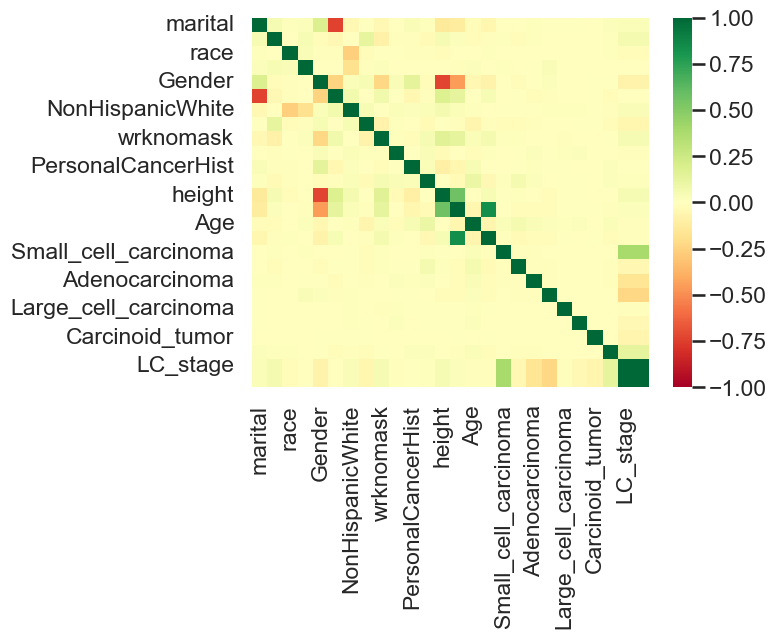

In [24]:
sns.heatmap(sybil_nlst_demos[nlst_democols['cat']['demo'] + nlst_democols['cat']['other'] + nlst_democols['num']['demo'] + nlst_democols['cat']['lungcanc']].corr(), cmap='RdYlGn', vmin=-1, vmax=1)

## Get Sybil Series for Z-shift check

In [30]:
nlst_preds = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds['InSybilTrain'].value_counts(dropna=False)

InSybilTrain
False    9545
True     6532
Name: count, dtype: int64

In [31]:
nlst_preds['Sybil_pred_label'] = (nlst_preds['sybil_year1'] > utils.ILST_THRESHOLD).astype(int).to_numpy()
nlst_preds['Sybil_PanCan_diff'] = nlst_preds['sybil_year1'] - nlst_preds['PanCan2b']

In [32]:
tp_train_top25 = nlst_preds.query("label == 1 and InSybilTrain == True").sort_values(by='PanCan2b', ascending=False).head(25)
tp_train_top25

PatientID  StudyDate  \
11080     200701   19990102   
10810     134491   20010102   
10104     131910   20010102   
4577      114798   20010102   
462       101387   19990102   
10103     131910   20000102   
7941      124864   20000102   
2245      107030   20010102   
13788     210774   20010102   
3224      110432   20000102   
12966     207954   19990102   
12889     207691   19990102   
10878     200168   19990102   
3223      110432   19990102   
4011      112851   19990102   
6362      120289   20010102   
12786     207286   19990102   
10102     131910   19990102   
15135     215585   20010102   
12046     204571   20010102   
9316      129285   19990102   
2110      106553   20010102   
13584     210090   20010102   
2109      106553   20000102   
11640     203166   19990102   

                                       SeriesInstanceUID      CoordX  \
11080  1.3.6.1.4.1.14519.5.2.1.7009.9004.236581477720...   29.180000   
10810  1.2.840.113654.2.55.87797263584059817420422842...   69.490000   
10104  1.2.840.113654.2.55.11424682138224056961138079...   53.450000   
4577   1.2.840.113654.2.55.23487052750859976164099967...   64.450000   
462    1.2.840.113654.2.55.17879920116288438977407432...  -32.180000   
10103  1.2.840.113654.2.55.29242056113599787146344690...   42.767593   
7941   1.2.840.113654.2.55.14059028299195631370217959...  -38.550000   
2245   1.2.840.113654.2.55.32286177794498629754922758...  -60.750000   
13788  1.3.6.1.4.1.14519.5.2.1.7009.9004.249370380378...  -72.769073   
3224   1.2.840.113654.2.55.21971240595572970235737477...  -25.340000   
12966  1.3.6.1.4.1.14519.5.2.1.7009.9004.128719895339...  -70.470000   
12889  1.3.6.1.4.1.14519.5.2.1.7009.9004.291893030174...   91.320000   
10878  1.3.6.1.4.1.14519.5.2.1.7009.9004.716317416517...   -7.800000   
3223   1.2.840.113654.2.55.26339742871741964030560032...  -27.810000   
4011   1.2.840.113654.2.55.30276220214859282848718508...   52.620000   
6362   1.2.840.113654.2.55.33421707637839469598560952...  -77.650000   
12786  1.3.6.1.4.1.14519.5.2.1.7009.9004.256022561495... -101.630000   
10102  1.2.840.113654.2.55.15238478201691542322334290...   53.435135   
15135  1.3.6.1.4.1.14519.5.2.1.7009.9004.234966162311...   38.070000   
12046  1.3.6.1.4.1.14519.5.2.1.7009.9004.161184109424...   26.140000   
9316   1.2.840.113654.2.55.32218491691014887992750680...  -61.800000   
2110   1.2.840.113654.2.55.18887628356060209734659781...   74.030000   
13584  1.3.6.1.4.1.14519.5.2.1.7009.9004.148800903815...   70.738281   
2109   1.2.840.113654.2.55.14660159465432299498263001...   83.948441   
11640  1.3.6.1.4.1.14519.5.2.1.7009.9004.785517485814...   35.010000   

           CoordY       CoordZ  LesionID  Spiculation  Diameter [mm]  Age  \
11080  102.780000 -1370.920000         2        False           60.4   61   
10810   65.090000  1588.160000         1         True           35.8   66   
10104 -140.420000  1236.360000         1        False           39.8   70   
4577    31.660000  -133.360000         1        False           45.0   61   
462     36.850000   -26.840000         1        False           44.6   63   
10103 -144.966782  1192.000000         1        False           34.8   69   
7941   -84.600000  -159.170000         1         True           19.2   66   
2245   -10.570000   -71.330000         1        False           44.5   75   
13788  -15.438705  -140.509979         1        False           22.6   66   
3224    15.320000  -196.060000         1        False           29.4   60   
12966 -154.900000  -206.880000         1        False           41.8   66   
12889   61.160000   -59.790000         1        False           23.1   66   
10878  -70.080000  -113.340000         1        False           27.3   55   
3223    13.200000  -162.000000         1        False           29.1   59   
4011    40.210000   -45.690000         1        False           24.4   67   
6362  -221.680000  -209.880000         1        False           26.5   69   
12786   94.900000 

In [34]:
tp_train_top25['SeriesInstanceUID'].tolist()

['1.3.6.1.4.1.14519.5.2.1.7009.9004.236581477720516135789038198297',
 '1.2.840.113654.2.55.87797263584059817420422842408163180099',
 '1.2.840.113654.2.55.114246821382240569611380795975517495817',
 '1.2.840.113654.2.55.234870527508599761640999671632707483702',
 '1.2.840.113654.2.55.17879920116288438977407432295523363002',
 '1.2.840.113654.2.55.292420561135997871463446905291579464035',
 '1.2.840.113654.2.55.14059028299195631370217959879698398394',
 '1.2.840.113654.2.55.322861777944986297549227585914529686199',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.249370380378363801265147641098',
 '1.2.840.113654.2.55.21971240595572970235737477312067482812',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.128719895339498507728437515897',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.291893030174859756508765761855',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.716317416517774495243426985223',
 '1.2.840.113654.2.55.263397428717419640305600326881280804821',
 '1.2.840.113654.2.55.30276220214859282848718508697843613549',
 '1.2.840.113654.2.5

In [2]:
## directory where results are
EXPERIMENT_DIR = f"V:/experiments/lung-malignancy-fairness-shaurya"
CHANSEY_NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
LOCAL_NLST_PREDS = f"{TEAMS_DIR}/nlst/Sybil-Heatmap-Info" ## Comment out if not using Teams backup (aka Chansey is up :)
NLST_PREDS = LOCAL_NLST_PREDS

In [21]:
tp_train_top25.to_csv(f"{CHANSEY_NLST_PREDS}/sybil_tp_train_top25.csv", index=False)
tp_train_top25.to_csv(f"{LOCAL_NLST_PREDS}/sybil_tp_train_top25.csv", index=False)

### Load data after z-shift check

In [5]:
tp_train_top25 = pd.read_csv(f"{LOCAL_NLST_PREDS}/sybil_tp_train_top25.csv")
tp_train_top25

PatientID  StudyDate                                  SeriesInstanceUID  \
0      200701   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.236581477720...   
1      134491   20010102  1.2.840.113654.2.55.87797263584059817420422842...   
2      131910   20010102  1.2.840.113654.2.55.11424682138224056961138079...   
3      114798   20010102  1.2.840.113654.2.55.23487052750859976164099967...   
4      101387   19990102  1.2.840.113654.2.55.17879920116288438977407432...   
5      131910   20000102  1.2.840.113654.2.55.29242056113599787146344690...   
6      124864   20000102  1.2.840.113654.2.55.14059028299195631370217959...   
7      107030   20010102  1.2.840.113654.2.55.32286177794498629754922758...   
8      210774   20010102  1.3.6.1.4.1.14519.5.2.1.7009.9004.249370380378...   
9      110432   20000102  1.2.840.113654.2.55.21971240595572970235737477...   
10     207954   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.128719895339...   
11     207691   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.291893030174...   
12     200168   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.716317416517...   
13     110432   19990102  1.2.840.113654.2.55.26339742871741964030560032...   
14     112851   19990102  1.2.840.113654.2.55.30276220214859282848718508...   
15     120289   20010102  1.2.840.113654.2.55.33421707637839469598560952...   
16     207286   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.256022561495...   
17     131910   19990102  1.2.840.113654.2.55.15238478201691542322334290...   
18     215585   20010102  1.3.6.1.4.1.14519.5.2.1.7009.9004.234966162311...   
19     204571   20010102  1.3.6.1.4.1.14519.5.2.1.7009.9004.161184109424...   
20     129285   19990102  1.2.840.113654.2.55.32218491691014887992750680...   
21     106553   20010102  1.2.840.113654.2.55.18887628356060209734659781...   
22     210090   20010102  1.3.6.1.4.1.14519.5.2.1.7009.9004.148800903815...   
23     106553   20000102  1.2.840.113654.2.55.14660159465432299498263001...   
24     203166   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.785517485814...   

        CoordX      CoordY       CoordZ  LesionID  Spiculation  Diameter [mm]  \
0    29.180000  102.780000 -1370.920000         2        False           60.4   
1    69.490000   65.090000  1588.160000         1         True           35.8   
2    53.450000 -140.420000  1236.360000         1        False           39.8   
3    64.450000   31.660000  -133.360000         1        False           45.0   
4   -32.180000   36.850000   -26.840000         1        False           44.6   
5    42.767593 -144.966782  1192.000000         1        False           34.8   
6   -38.550000  -84.600000  -159.170000         1         True           19.2   
7   -60.750000  -10.570000   -71.330000         1        False           44.5   
8   -72.769073  -15.438705  -140.509979         1        False           22.6   
9   -25.340000   15.320000  -196.060000         1        False           29.4   
10  -70.470000 -154.900000  -206.880000         1        False           41.8   
11   91.320000   61.160000   -59.790000         1        False           23.1   
12   -7.800000  -70.080000  -113.340000         1        False           27.3   
13  -27.810000   13.200000  -162.000000         1        False           29.1   
14   52.620000   40.210000   -45.690000         1        False           24.4   
15  -77.650000 -221.680000  -209.880000         1        False           26.5   
16 -101.630000   94.900000 -1410.010000         1        False           43.1   
17   53.435135 -127.616394   -89.000000         1        False           25.3   
18   38.070000   59.680000  -131.540000         1        False           31.3   
19   26.140000    6.170000   -21.130000         1        False           18.4   
20  -61.800000   47.030000   -48.410000         1        False           39.0   
21   74.030000    8.270000  -100.010000         1        False           39.1   
22   70.738281 -174.261719  -107.500000         1        False           33.8   
23   

In [6]:
sybil_inference_tp_train = pd.read_csv(f"{CHANSEY_NLST_PREDS}/sybil_attentions_tp_train/inference.csv")
sybil_inference_tp_train

SeriesInstanceUID     year1     year2  \
0   1.2.840.113654.2.55.32218491691014887992750680...  0.900000  0.950000   
1   1.2.840.113654.2.55.30276220214859282848718508...  0.855623  0.916718   
2   1.3.6.1.4.1.14519.5.2.1.7009.9004.256022561495...  0.454672  0.601673   
3   1.2.840.113654.2.55.32286177794498629754922758...  0.680410  0.799003   
4   1.2.840.113654.2.55.15238478201691542322334290...  0.126129  0.201569   
5   1.2.840.113654.2.55.11424682138224056961138079...  0.421667  0.568750   
6   1.3.6.1.4.1.14519.5.2.1.7009.9004.236581477720...  0.493488  0.650193   
7   1.3.6.1.4.1.14519.5.2.1.7009.9004.128719895339...  0.601256  0.739206   
8   1.3.6.1.4.1.14519.5.2.1.7009.9004.716317416517...  0.003951  0.015674   
9   1.3.6.1.4.1.14519.5.2.1.7009.9004.785517485814...  0.255630  0.366772   
10  1.3.6.1.4.1.14519.5.2.1.7009.9004.234966162311...  0.900000  0.950000   
11  1.2.840.113654.2.55.21971240595572970235737477...  0.080999  0.143517   
12  1.3.6.1.4.1.14519.5.2.1.7009.9004.291893030174...  0.351667  0.463217   
13  1.2.840.113654.2.55.17879920116288438977407432...  0.316431  0.425500   
14  1.3.6.1.4.1.14519.5.2.1.7009.9004.148800903815...  0.290392  0.401270   
15  1.2.840.113654.2.55.29242056113599787146344690...  0.290392  0.400331   
16  1.2.840.113654.2.55.14660159465432299498263001...  0.474835  0.626877   
17  1.3.6.1.4.1.14519.5.2.1.7009.9004.249370380378...  0.131129  0.201569   
18  1.2.840.113654.2.55.14059028299195631370217959...  0.894284  0.945713   
19  1.3.6.1.4.1.14519.5.2.1.7009.9004.161184109424...  0.131679  0.201569   
20  1.2.840.113654.2.55.33421707637839469598560952...  0.268964  0.379487   
21  1.2.840.113654.2.55.87797263584059817420422842...  0.290392  0.394906   
22  1.2.840.113654.2.55.18887628356060209734659781...  0.450366  0.596291   
23  1.2.840.113654.2.55.23487052750859976164099967...  0.105322  0.167839   
24  1.2.840.113654.2.55.26339742871741964030560032...  0.127051  0.201569   

       year3     year4     year5     year6  
0   0.950000  0.950000  0.950000  0.950000  
1   0.916718  0.924642  0.924642  0.924642  
2   0.656374  0.674231  0.714681  0.759267  
3   0.808296  0.830920  0.852877  0.870926  
4   0.207000  0.236478  0.248381  0.307637  
5   0.627222  0.645079  0.675261  0.734049  
6   0.693637  0.711494  0.755939  0.799209  
7   0.762538  0.782836  0.815766  0.846308  
8   0.025373  0.034919  0.043507  0.063896  
9   0.381081  0.404818  0.419659  0.475395  
10  0.950000  0.950000  0.950000  0.950000  
11  0.172521  0.197799  0.211975  0.276596  
12  0.508478  0.530231  0.573024  0.652839  
13  0.481122  0.485018  0.527437  0.608408  
14  0.445585  0.449481  0.486245  0.584663  
15  0.444208  0.448104  0.484650  0.583743  
16  0.675730  0.693587  0.738032  0.779392  
17  0.219445  0.240922  0.258381  0.323277  
18  0.945713  0.946734  0.946734  0.946734  
19  0.219445  0.240922  0.258381  0.323277  
20  0.413636  0.417532  0.449214  0.563316  
21  0.436252  0.440148  0.475428  0.578427  
22  0.652241  0.670098  0.709521  0.754796  
23  0.189976  0.217799  0.229753  0.300137  
24  0.207000  0.236478  0.248381  0.308361

In [8]:
merged_tp_top25 = pd.merge(tp_train_top25, sybil_inference_tp_train, how='outer', on='SeriesInstanceUID', suffixes=('',''))
merged_tp_top25

PatientID  StudyDate                                  SeriesInstanceUID  \
0      131910   20010102  1.2.840.113654.2.55.11424682138224056961138079...   
1      124864   20000102  1.2.840.113654.2.55.14059028299195631370217959...   
2      106553   20000102  1.2.840.113654.2.55.14660159465432299498263001...   
3      131910   19990102  1.2.840.113654.2.55.15238478201691542322334290...   
4      101387   19990102  1.2.840.113654.2.55.17879920116288438977407432...   
5      106553   20010102  1.2.840.113654.2.55.18887628356060209734659781...   
6      110432   20000102  1.2.840.113654.2.55.21971240595572970235737477...   
7      114798   20010102  1.2.840.113654.2.55.23487052750859976164099967...   
8      110432   19990102  1.2.840.113654.2.55.26339742871741964030560032...   
9      131910   20000102  1.2.840.113654.2.55.29242056113599787146344690...   
10     112851   19990102  1.2.840.113654.2.55.30276220214859282848718508...   
11     129285   19990102  1.2.840.113654.2.55.32218491691014887992750680...   
12     107030   20010102  1.2.840.113654.2.55.32286177794498629754922758...   
13     120289   20010102  1.2.840.113654.2.55.33421707637839469598560952...   
14     134491   20010102  1.2.840.113654.2.55.87797263584059817420422842...   
15     207954   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.128719895339...   
16     210090   20010102  1.3.6.1.4.1.14519.5.2.1.7009.9004.148800903815...   
17     204571   20010102  1.3.6.1.4.1.14519.5.2.1.7009.9004.161184109424...   
18     215585   20010102  1.3.6.1.4.1.14519.5.2.1.7009.9004.234966162311...   
19     200701   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.236581477720...   
20     210774   20010102  1.3.6.1.4.1.14519.5.2.1.7009.9004.249370380378...   
21     207286   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.256022561495...   
22     207691   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.291893030174...   
23     200168   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.716317416517...   
24     203166   19990102  1.3.6.1.4.1.14519.5.2.1.7009.9004.785517485814...   

        CoordX      CoordY       CoordZ  LesionID  Spiculation  Diameter [mm]  \
0    53.450000 -140.420000  1236.360000         1        False           39.8   
1   -38.550000  -84.600000  -159.170000         1         True           19.2   
2    83.948441    6.679688   -90.415001         1        False           38.6   
3    53.435135 -127.616394   -89.000000         1        False           25.3   
4   -32.180000   36.850000   -26.840000         1        False           44.6   
5    74.030000    8.270000  -100.010000         1        False           39.1   
6   -25.340000   15.320000  -196.060000         1        False           29.4   
7    64.450000   31.660000  -133.360000         1        False           45.0   
8   -27.810000   13.200000  -162.000000         1        False           29.1   
9    42.767593 -144.966782  1192.000000         1        False           34.8   
10   52.620000   40.210000   -45.690000         1        False           24.4   
11  -61.800000   47.030000   -48.410000         1        False           39.0   
12  -60.750000  -10.570000   -71.330000         1        False           44.5   
13  -77.650000 -221.680000  -209.880000         1        False           26.5   
14   69.490000   65.090000  1588.160000         1         True           35.8   
15  -70.470000 -154.900000  -206.880000         1        False           41.8   
16   70.738281 -174.261719  -107.500000         1        False           33.8   
17   26.140000    6.170000   -21.130000         1        False           18.4   
18   38.070000   59.680000  -131.540000         1        False           31.3   
19   29.180000  102.780000 -1370.920000         2        False           60.4   
20  -72.769073  -15.438705  -140.509979         1        False           22.6   
21 -101.630000   94.900000 -1410.010000         1        False           43.1   
22   91.320000   61.160000   -59.790000         1        False           23.1   
23   

In [9]:
merged_tp_top25.to_csv(f"{LOCAL_NLST_PREDS}/sybil_tp_train_top25.csv")

## Do we have Sybil's NLST data on our drives?

In [2]:
SYBIL_ANNOT_PATH = f"{TEAMS_DIR}/sybil-train-info/sybil-nlst-train-annotations.json"
with open(SYBIL_ANNOT_PATH, "r") as f:
    sybil_annots = json.load(f)

sybil_annots

{'1.2.840.113654.2.55.38995485391900019876570761037952058249': {'1.2.840.113654.2.55.275160439012050074323170831804208812984': [{'x': 0.17459896484375,
    'y': 0.30871669921875,
    'width': 0.04600482421875,
    'height': 0.0411622265625}],
  '1.2.840.113654.2.55.98336108916096429974899588868734477535': [{'x': 0.1637030859375,
    'y': 0.3111380078125,
    'width': 0.052058125,
    'height': 0.04479419921875}],
  '1.2.840.113654.2.55.280972815401648915903374779039953078123': [{'x': 0.14191130859375,
    'y': 0.59443099609375,
    'width': 0.05811138671875,
    'height': 0.0532687890625}],
  '1.2.840.113654.2.55.247917605354156964140382450551544417059': [{'x': 0.135858046875,
    'y': 0.58111380859375,
    'width': 0.07627119140625,
    'height': 0.07263921875}],
  '1.2.840.113654.2.55.237930085150267046743514220912827705415': [{'x': 0.58745046875,
    'y': 0.69875423828125,
    'width': 0.07021515625,
    'height': 0.0520951171875}],
  '1.2.840.113654.2.55.622628924705130611737708118

In [3]:
sybil_ser_iuids = pd.Series(list(sybil_annots.keys()))
sybil_sop_iuids = pd.Series(sum([list(a.keys()) for a in sybil_annots.values()], start=[]))
len(sybil_ser_iuids), len(sybil_sop_iuids)

(972, 9273)

In [4]:
sybil_siuid_df = pd.read_csv(f"{NLST_PREDS}/sybil-nlst-splitinfo.csv")
sybil_siuid_df['pid'] = sybil_siuid_df['pid'].astype(int)
sybil_siuid_df['timepoint'] = sybil_siuid_df['timepoint'].astype(int)
sybil_siuid_df['pid'].nunique()
sybil_siuid_df

id  split     pid  \
0      PID-204631__TimePoint-0__Series-1.3.6.1.4.1.14...  train  204631   
1      PID-204631__TimePoint-1__Series-1.3.6.1.4.1.14...  train  204631   
2      PID-204631__TimePoint-2__Series-1.3.6.1.4.1.14...  train  204631   
3      PID-126153__TimePoint-2__Series-1.2.840.113654...  train  126153   
4      PID-126153__TimePoint-1__Series-1.2.840.113654...  train  126153   
...                                                  ...    ...     ...   
41275  PID-133831__TimePoint-2__Series-1.2.840.113654...   test  133831   
41276  PID-133831__TimePoint-0__Series-1.2.840.113654...   test  133831   
41277  PID-116981__TimePoint-0__Series-1.2.840.113654...   test  116981   
41278  PID-116981__TimePoint-2__Series-1.2.840.113654...   test  116981   
41279  PID-116981__TimePoint-1__Series-1.2.840.113654...   test  116981   

       timepoint                                  SeriesInstanceUID  
0              0  1.3.6.1.4.1.14519.5.2.1.7009.9004.186764828479...  
1              1  1.3.6.1.4.1.14519.5.2.1.7009.9004.154974321095...  
2              2  1.3.6.1.4.1.14519.5.2.1.7009.9004.181632252038...  
3              2  1.2.840.113654.2.55.43665829455927473870872470...  
4              1  1.2.840.113654.2.55.18862732764668567267836753...  
...          ...                                                ...  
41275          2  1.2.840.113654.2.55.26279217761753193890516762...  
41276          0  1.2.840.113654.2.55.23986337370551290634823184...  
41277          0  1.2.840.113654.2.55.16179604920107519147811774...  
41278          2  1.2.840.113654.2.55.59492406653704762882979549...  
41279          1  1.2.840.113654.2.55.64498551494685723700722207...  

[41280 rows x 5 columns]

In [5]:
sybil_splits = sybil_siuid_df.groupby('split')
sybil_splits.nunique()

id   pid  timepoint  SeriesInstanceUID
split                                           
dev     6838  2336          3               6838
test    6282  2203          3               6282
train  28160  9646          3              28160

In [6]:
nlst_overview = pd.read_csv(f"W:/experiments/lung-malignancy-fairness-shaurya/nlst/overview.csv").dropna(axis=1)
nlst_overview

PatientID PatientName  PatientPath  StudyDate StudyDescription  \
0          122083  055913^LSS       122083   20010102         NLST-LSS   
1          122083  055913^LSS       122083   20010102         NLST-LSS   
2          122083  055913^LSS       122083   19990102         NLST-LSS   
3          122083  055913^LSS       122083   19990102         NLST-LSS   
4          122083  055913^LSS       122083   20000102         NLST-LSS   
...           ...         ...          ...        ...              ...   
195354     102913  008508^LSS       102913   19990102         NLST-LSS   
195355     102913  008508^LSS       102913   19990102         NLST-LSS   
195356     102913  008508^LSS       102913   20010102         NLST-LSS   
195357     102913  008508^LSS       102913   20010102         NLST-LSS   
195358     102913  008508^LSS       102913   20010102         NLST-LSS   

                                         StudyInstanceUID     StudyPath  \
0       1.2.840.113654.2.55.10843585897858991797435966...  122083/st000   
1       1.2.840.113654.2.55.10843585897858991797435966...  122083/st000   
2       1.2.840.113654.2.55.24402033609623795984389650...  122083/st001   
3       1.2.840.113654.2.55.24402033609623795984389650...  122083/st001   
4       1.2.840.113654.2.55.30204490687351113838577862...  122083/st002   
...                                                   ...           ...   
195354  1.2.840.113654.2.55.42909072755465622368991406...  102913/st001   
195355  1.2.840.113654.2.55.42909072755465622368991406...  102913/st001   
195356  1.2.840.113654.2.55.75189009649631570444325487...  102913/st002   
195357  1.2.840.113654.2.55.75189009649631570444325487...  102913/st002   
195358  1.2.840.113654.2.55.75189009649631570444325487...  102913/st002   

        SeriesNumber Modality  \
0                  2       CT   
1                  1       CT   
2                  2       CT   
3                  1       CT   
4                  2       CT   
...              ...      ...   
195354             1       CT   
195355             3       CT   
195356             2       CT   
195357             3       CT   
195358             1       CT   

                                       SeriesDescription  ...  \
0         2,OPA,GE,LSPLUS,STANDARD,360,2.5,140,841,na,na  ...   
1          2,OPL,GE,LSPLUS,STANDARD,null,na,120,44,na,na  ...   
2          0,OPA,GE,LSPLUS,STANDARD,303,2.5,140,40,0,1.5  ...   
3       0,OPL,GE,LSPLUS,EXPERIMENTAL7,null,na,120,0,0,na  ...   
4          1,OPA,GE,LSPLUS,STANDARD,320,2.5,140,40,0,1.5  ...   
...                                                  ...  ...   
195354          0,OPL,SE,VZOOM,T20s,512,na,80,245,245,na  ...   
195355            0,OPA,SE,VZOOM,B30f,360,2,120,60,30,na  ...   
195356            2,OPA,SE,VZOOM,B50f,370,2,120,60,30,na  ...   
195357            2,OPA,SE,VZOOM,B30f,370,2,120,60,30,na  ...   
195358          2,OPL,SE,VZOOM,T20s,512,na,80,226,226,na  ...   

        RescaleIntercept  RescaleSlope    KVP        Manufacturer  \
0                -1024.0           1.0  140.0  GE MEDICAL SYSTEMS   
1                -1024.0           1.0  120.0  GE MEDICAL SYSTEMS   
2                    0.0           1.0  140.0  GE MEDICAL SYSTEMS   
3                    0.0           1.0  120.0  GE MEDICAL SYSTEMS   
4                -1024.0           1.0  140.0  GE MEDICAL SYSTEMS   
...                  ...           ...    ...                 ...   
195354           -1024.0           1.0   80.0             SIEMENS   
195355           -1024.0           1.0  120.0             SIEMENS   
195356           -1024.0           1.0  120.0             SIEMENS   
195357           -1024.0           1.0  120.0             SIEMENS   
195358           -1024.0           1.0   80.0             SIEMENS   

       ManufacturersModelName                SOPClassUID  \
0             LightSpeed Plus  1.2.840.10008.5.1.4.1.1.2   
1             LightSpeed Plus  1.2.840.10008.5.1.4.1.1.2   
2             LightSpeed Plus  

In [7]:
nlst_overview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195359 entries, 0 to 195358
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PatientID                  195359 non-null  int64  
 1   PatientName                195359 non-null  object 
 2   PatientPath                195359 non-null  int64  
 3   StudyDate                  195359 non-null  int64  
 4   StudyDescription           195359 non-null  object 
 5   StudyInstanceUID           195359 non-null  object 
 6   StudyPath                  195359 non-null  object 
 7   SeriesNumber               195359 non-null  int64  
 8   Modality                   195359 non-null  object 
 9   SeriesDescription          195359 non-null  object 
 10  Rows                       195359 non-null  int64  
 11  Columns                    195359 non-null  int64  
 12  SliceThickness             195359 non-null  float64
 13  PixelSpacing               19

In [8]:
nlst_dcm_series = pd.unique(nlst_overview.query('HasValidImageVolume == True')['SeriesInstanceUID'])
nlst_dcm_set = set(nlst_dcm_series)
nlst_dcm_series[0:20]

array(['1.2.840.113654.2.55.266806578463459450613671576394976467189',
       '1.2.840.113654.2.55.106421277710386273060718300867728118507',
       '1.2.840.113654.2.55.199337888247686126905326636025901212264',
       '1.2.840.113654.2.55.35217459519970642215787119544572142964',
       '1.2.840.113654.2.55.127687403748158754795316206338682655802',
       '1.2.840.113654.2.55.115730963406163847932221486230545429405',
       '1.2.840.113654.2.55.15665038100715016747168226242404200989',
       '1.2.840.113654.2.55.176105001927884197247857514281183189296',
       '1.2.840.113654.2.55.151114461795930788049143933116620027942',
       '1.2.840.113654.2.55.292731326436456353695207286078623365309',
       '1.2.840.113654.2.55.180884807313181570545927158945017934595',
       '1.2.840.113654.2.55.160453426987970047604454522684442736319',
       '1.2.840.113654.2.55.205691841869538597065316503377147564074',
       '1.2.840.113654.2.55.217638637854278216454440011193475434763',
       '1.2.840.113654

In [9]:
nlst_mha_series = [f.split(".mha")[0] for f in os.listdir(f"W:/experiments/0-nlst-mha")]
print(len(nlst_mha_series))
nlst_mha_series[0:20]

35576


['1.2.840.113654.2.55.199226445922767178295995012210945516690',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.148536123354815759746118275995',
 '1.2.840.113654.2.55.323222458410185103775283622447488300104',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.110967217570677318190897981574',
 '1.2.840.113654.2.55.282079879328885586483800977756382149450',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.124874247030061014771302392474',
 '1.2.840.113654.2.55.110941678170095669992879218627447756061',
 '1.2.840.113654.2.55.8502505455986898938947143652409769266',
 '1.2.840.113654.2.55.219267391138802796379149176633861811876',
 '1.2.840.113654.2.55.60012952842931984321748813092964590658',
 '1.2.840.113654.2.55.267102421083318156216731580153537715252',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.274864899329458805359494586539',
 '1.2.840.113654.2.55.267038041464578337970849630135644546863',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.126465035015320134597270939962',
 '1.2.840.113654.2.55.53471277335003338545153245245555257736',
 '1.2.840.113654.2.

In [10]:
nlst_mha_set = set(nlst_mha_series)

In [11]:
for split_name, split_df in sybil_splits:
    print(f"\n{split_name}: {split_df['SeriesInstanceUID'].nunique()} series, {split_df['pid'].nunique()} patients")
    series_set = set(split_df['SeriesInstanceUID'])
    
    annot_ser_int = series_set.intersection(set(sybil_ser_iuids))
    print(f"- includes {len(annot_ser_int)}/{len(sybil_ser_iuids)} annotation series")

    nlst_mha_int = series_set.intersection(nlst_mha_set)
    print(f"- {len(nlst_mha_int)}/{len(series_set)} series found in 0-nlst-mha on Chansey")

    nlst_dcm_int = series_set.intersection(nlst_dcm_set)
    print(f"- {len(nlst_dcm_int)}/{len(series_set)} series found in NLST overview on bodyct2")

    missing_dcm = series_set - nlst_dcm_set
    print(f"- {len(missing_dcm)} missing series, {len(missing_dcm.intersection(nlst_mha_set))} in MHA folder")

    # for dcm in missing_dcm:
    #     print(f"  - {dcm}")
    #     print(f"    - in mha? {dcm in nlst_mha_set}")


dev: 6838 series, 2336 patients
- includes 152/972 annotation series
- 2564/6838 series found in 0-nlst-mha on Chansey
- 6593/6838 series found in NLST overview on bodyct2
- 245 missing series, 0 in MHA folder

test: 6282 series, 2203 patients
- includes 93/972 annotation series
- 2385/6282 series found in 0-nlst-mha on Chansey
- 6090/6282 series found in NLST overview on bodyct2
- 192 missing series, 0 in MHA folder

train: 28160 series, 9646 patients
- includes 643/972 annotation series
- 10863/28160 series found in 0-nlst-mha on Chansey
- 27262/28160 series found in NLST overview on bodyct2
- 898 missing series, 0 in MHA folder


In [12]:
nlst_overview.query('HasValidImageVolume == False')['SeriesPath']

1         122083/st000/se001
3         122083/st001/se001
5         122083/st002/se001
6         102279/st000/se000
9         102279/st001/se001
                 ...        
195224    119598/st001/se001
195225    119598/st002/se000
195248    211114/st000/se001
195311    131971/st001/se000
195314    131971/st002/se001
Name: SeriesPath, Length: 28801, dtype: object